In [6]:
import pytorch_lightning as pl
from distributions import *
from dataloaders import *
from visualization import *

from mappers import *
from model import *

In [7]:
import warnings
import logging

warnings.filterwarnings("ignore", message=".*ModelCheckpoint.*")
warnings.filterwarnings("ignore", message=".*val_dataloader.*")
warnings.filterwarnings("ignore", message=".*num_workers.*")

pl_logger = logging.getLogger("pytorch_lightning")
pl_logger.setLevel(logging.WARNING)  # or logging.ERROR

PlotUtils.set_style()

# MNIST Dataloader

In [8]:
num_classes = 10
max_train_samples = 10000
train_loader, test_loader = get_dataloaders(
    dataset_name='mnist', batch_size = max_train_samples, num_views=1,
    contrastive = False, size=28, with_augmentation = False, num_workers = 0,
    max_train_samples=max_train_samples 
)
test_loader = train_loader

In [9]:
from pytorch_lightning.loggers import TensorBoardLogger

def run_model(model, plot_logger, max_epochs=60, check_val_every_n_epoch=30, exp_name='default'):
    # 1. Create the TensorBoard logger with experiment name
    logger = TensorBoardLogger("notebook_logs", name=exp_name)
    logger.log_hyperparams(model.hparams)

    # 2. Create the trainer with logger and callbacks
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        check_val_every_n_epoch=check_val_every_n_epoch,
        log_every_n_steps=1,
        callbacks=[plot_logger],
        logger=logger
    )

    # 3. Fit the model
    trainer.fit(model, train_loader, test_loader)
    return model


In [10]:
models = {}

# Dimensionality Reduction

## Parametric SNE

In [11]:
plt_config = PlotConfig(backend="matplotlib")

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

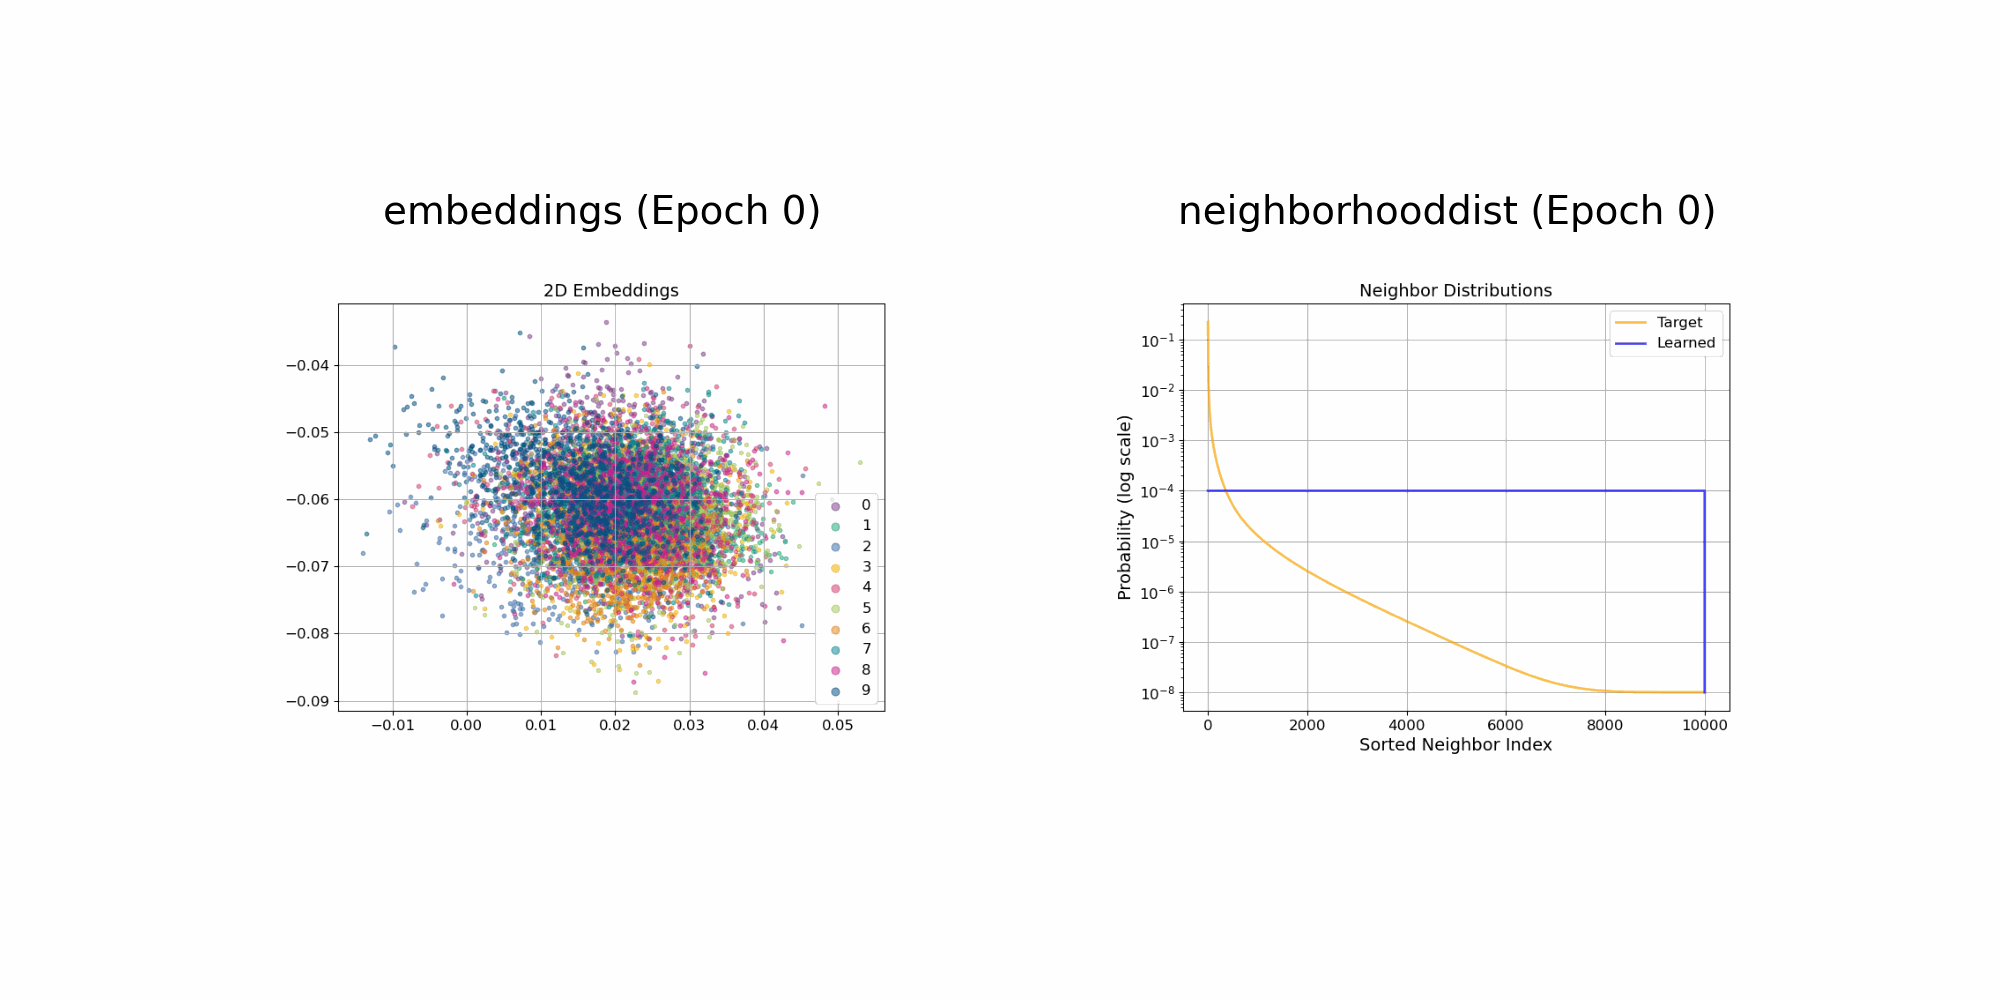

In [12]:
config = Config(   
    mapper = SimpleCNN(output_dim=2, input_key= "image", output_key= "embedding"),
    supervisory_distribution = Gaussian(sigma = 5, input_key= "image", mask_diagonal = True),
    learned_distribution = Gaussian(sigma = 1, input_key= "embedding", mask_diagonal = True),
    use_mixed_precision = True,
    lr= 1e-3,)

plt_logger = PlotLogger(plots=[EmbeddingsPlot(plt_config), NeighborhoodDistPlot(plt_config)])


model = Model(config)
model = run_model(model, plt_logger, max_epochs= 4, check_val_every_n_epoch=1, exp_name = 'parametric_SNE')
models['parametric_SNE'] = model

## Parametric t-SNE

In [ ]:
icon_config = Config(
    mapper = SimpleCNN(output_dim=2, input_key= "image", output_key= "embedding"),
    supervisory_distribution = Gaussian(sigma = 5, input_key= "image", mask_diagonal = True),
    learned_distribution = StudentT(gamma = 1, input_key= "embedding", mask_diagonal = True),
    use_mixed_precision = True,
    lr= 5e-3,)


plot_logger = PlotLogger(
    plots=[EmbeddingsPlot(plt_config), NeighborhoodDistPlot(plt_config)],
    save_path="./plots",
)

model = Model(icon_config)
model = run_model(model, plot_logger, max_epochs= 50, check_val_every_n_epoch=1)
models['parametric_tSNE'] = model

## Non-Parametric t-SNE

In [ ]:
from sklearn.decomposition import PCA
features = gather_batch_tensors(train_loader, "image", "index", max_train_samples)
pca = PCA(n_components=2)
components = pca.fit_transform(features.cpu().numpy())
init_weights = torch.tensor(components, dtype=torch.float32)


In [ ]:
config = Config(mapper = LookUpTable(num_embeddings=max_train_samples, embedding_dim=2, 
                                              input_key ="index", output_key= "embedding", 
                                              init_weights = init_weights),
                         supervisory_distribution = UniformKNN(k = 100, mask_diagonal = True, input_key ="image"),
                         learned_distribution = StudentT(gamma = 1, mask_diagonal = True, input_key ="embedding"),
                         lr=1,
                        )

plot_logger = PlotLogger([EmbeddingsPlot(), NeighborhoodDistPlot()], save_path = './non-parametric_tSNE_with_uniform_affinities', show_plots = False)
model = Model(config)
model = run_model(model, plot_logger, max_epochs= 150, check_val_every_n_epoch=1)
models['nonparametric_tSNE'] = model

# Contrastive Methods

## Supervised Contrastive Learning

In [ ]:
config = Config(
    mapper = SimpleCNN(output_dim=3, unit_sphere = True, input_key= "image", output_key= "embedding"),
    supervisory_distribution = Label(input_key= "label"),
    learned_distribution = Gaussian(sigma = 0.4, input_key = "embedding"),
    
    accuracy_mode = 'regular',
    num_classes = num_classes,
    linear_probe = True,
    lr = 5e-3)

plot_logger = PlotLogger([EmbeddingsPlot(), NeighborhoodDistPlot()], save_path = './supcon', show_plots = False)
model = Model(config)
model = run_model(model, plot_logger, max_epochs= 150, check_val_every_n_epoch=1)
models['supcon'] = model

## SimCLR

In [ ]:
train_loader, test_loader = get_dataloaders(
    dataset_name='mnist', batch_size = 2*max_train_samples, num_views=2,
    contrastive = True, size=28, with_augmentation = False, num_workers = 0,
    max_train_samples=max_train_samples 
)
test_loader = train_loader

In [ ]:
config = Config(mapper = SimpleCNN(output_dim=3, unit_sphere = True, 
                                              input_key= ["image", "image1"], 
                                              output_key= ["embedding", "embedding1"]),
                           
                           supervisory_distribution = Augmentation(block_size=1, input_key = "index"),
                           learned_distribution = Gaussian(sigma = 0.5, metric="dot", input_key = "embedding", input_key2 = "embedding1"),
                           accuracy_mode = 'regular',
                           num_classes = num_classes,
                           linear_probe = True,
                           lr = 1e-3,
                        )
plot_logger = PlotLogger([])
model = Model(config)
model = run_model(model, plot_logger, max_epochs= 100, check_val_every_n_epoch=50)
models['simclr'] = model

# t-SimCLR

In [ ]:
config = Config(mapper = SimpleCNN(output_dim=3, unit_sphere = True,  input_key= ["image", "image1"], output_key= ["embedding", "embedding1"]),
                           
                supervisory_distribution = Augmentation(block_size=1, input_key = "index"),
                learned_distribution = StudentT(gamma = 0.5, input_key = "embedding", input_key2 = "embedding1"),
                accuracy_mode = 'regular',
                num_classes = num_classes,
                linear_probe = True,
                lr = 1e-4,
                )
plot_logger = PlotLogger([EmbeddingsPlot(), NeighborhoodDistPlot()])
model = Model(config)
model = run_model(model, plot_logger, max_epochs= 100, check_val_every_n_epoch=50)
models['tsimclr'] = model

# Cross Entropy

In [ ]:
dim = 128

cnn = SimpleCNN(output_dim=dim, input_key= "image", output_key = "embedding")
class_lookup = LookUpTable(num_embeddings=10, embedding_dim=dim, input_key ="label", output_key= "class-embedding", get_all = True)

config = Config(
                       mapper = [cnn, class_lookup],
                       supervisory_distribution = Label(pairwise= False, num_classes = 10, mask_diagonal = False, input_key = "label"),
                       learned_distribution= Gaussian(sigma = 0.5, metric= 'dot', mask_diagonal = False, 
                                                      input_key = "embedding", input_key2 = "class-embedding"),
                       lr = 0.001
                      )

plot_logger = PlotLogger([NeighborhoodDistPlot(),  ProbabilitiesStarPlot(probabilities_key = 'learned_distribution')], save_path = './supervised_CE', show_plots = False)
model = Model(config)
model = run_model(model, plot_logger, max_epochs= 150, check_val_every_n_epoch=1)
models['supervisedCE'] = model

## Harmonic Loss

In [ ]:
dim = 128

cnn = SimpleCNN(output_dim=dim, input_key= "image", output_key = "embedding")
class_lookup = LookUpTable(num_embeddings=10, embedding_dim=dim, input_key ="label", output_key= "class-embedding", get_all = True)

classification_config = Config(
                       mapper = [cnn, class_lookup],
                       supervisory_distribution = Label(pairwise= False, num_classes = 10,  input_key = "label"),
                       learned_distribution= StudentT(gamma = 0.1, input_key = "embedding", input_key2 = "class-embedding"),
                       lr = 0.001
                      )
plot_logger = SimplePlotLogger([NeighborhoodDistPlot(), ProbabilitiesStarPlot(probabilities_key = 'learned_distribution')], show_plots=True, columns=2)

model = Model(classification_config)
model = run_model(model, plot_logger)